# Time Series Regression
In this notebook, we will be using the following machine learning models for time series of World Happiness:

- Autoregression on Score (AR)
- Autoregressive Integrated Moving Average on Score (ARIMA)
- AR/ARIMA on Variables followed by Huber Regression
- Vector Autoregression on Variables and Score

Firstly, let us take a look at our data (We will use United States as an example)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)
warnings.simplefilter(action='ignore', category= UserWarning)

             Score   Economy    Family    Health   Freedom  Generosity  \
Year                                                                     
2015-01-01  7.1190  1.394510  1.247110  0.861790  0.546040    0.401050   
2016-01-01  7.1040  1.507960  1.047820  0.779000  0.481630    0.410770   
2017-01-01  6.9930  1.546259  1.419921  0.774287  0.505741    0.392579   
2018-01-01  6.8860  1.398000  1.471000  0.819000  0.547000    0.291000   
2019-01-01  6.8920  1.433000  1.457000  0.874000  0.454000    0.280000   
2020-01-01  6.9396  1.092577  0.914219  0.682995  0.842620    0.149892   
2021-01-01  6.9510  1.102300  0.920000  0.682000  0.837000    0.098000   

               Trust  
Year                  
2015-01-01  0.158900  
2016-01-01  0.148680  
2017-01-01  0.135639  
2018-01-01  0.133000  
2019-01-01  0.128000  
2020-01-01  0.699715  
2021-01-01  0.698000  


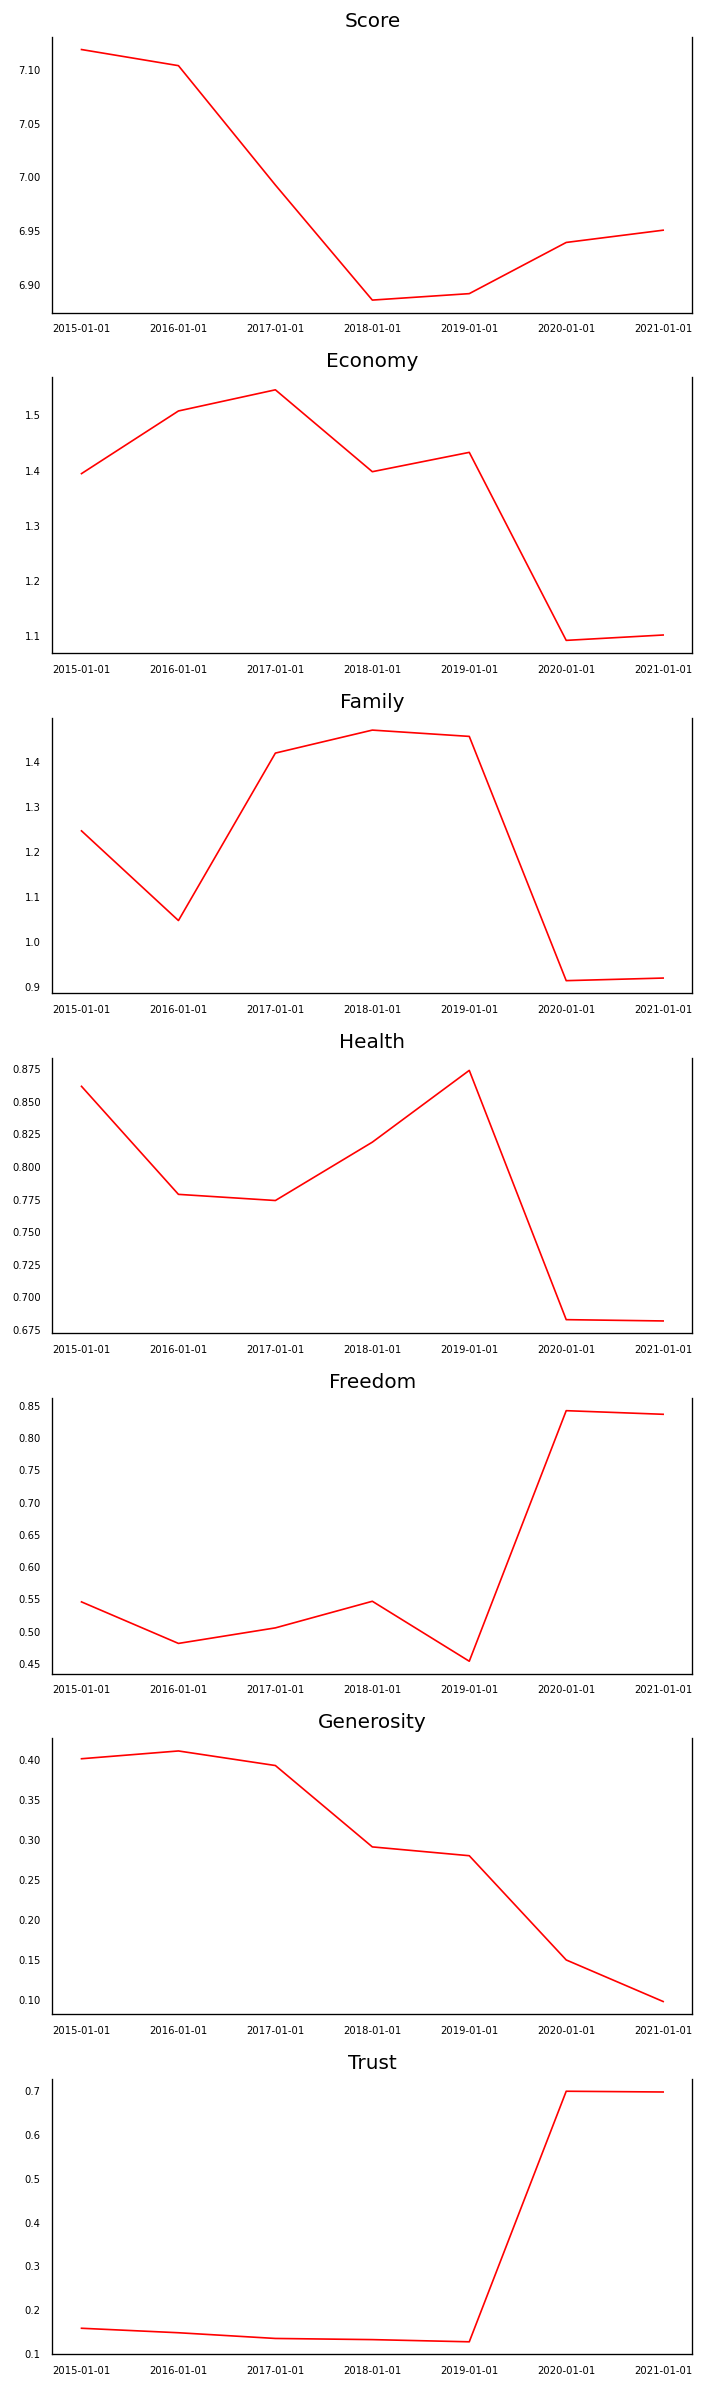

In [3]:
data = {}
for x in range (2015,2022):
    data[x] = pd.read_csv(f'../cleaned_data/{str(x)}.csv')
countries = data[2015]['Country']

time = {}
for x in countries:
    time[x] = pd.read_csv(f'../time_series/{x}.csv')
    time[x] = time[x].set_index('Year')

# Example of time series: United States
df = time['United States']
print(df)
fig, axes = plt.subplots(nrows=7, ncols=1, dpi=120, figsize=(6,20))
for i, ax in enumerate(axes.flatten()):
    ax.plot(df[df.columns[i]], color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# 1. Autoregression on Score
Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. These steps are called lag. For our time series, we will be using lag of 1 to train our model. Although larger lag is recommended, we have to compromise due to having small number of data points.

In [20]:
time['United States']['Score'].tolist()

[7.119, 7.104, 6.99300003051758, 6.886, 6.892, 6.939599991, 6.951]

In [50]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

ar_score_pred = data[2021][['Country','Score']].copy()
ar_pred_list = []

#Applying model on all countries
for country in countries:
    df = time[country]['Score']

    df_stationarityTest = adfuller(df, autolag='AIC')
    
    train_data, test_data = df[0:6], df[6]
    ar_model = AutoReg(df,lags = 1).fit()
    pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)
    ar_pred_list.append(pred.values[0])
    
ar_score_pred['Pred'] = ar_pred_list
ar_score_pred

,Country,Score,Pred
0,Afghanistan,2.523,2.476479
1,Albania,5.117,4.843039
2,Algeria,4.887,5.052512
3,Argentina,5.929,5.864534
4,Armenia,5.283,5.130953
...,...,...,...
131,Venezuela,4.892,4.914779
132,Vietnam,5.411,5.263967
133,Yemen,3.658,3.509848
134,Zambia,4.073,3.823447


In [51]:
# Finding Mean Squared Error (MSE)
error_sum = 0
ar_score_list = ar_score_pred['Score'].tolist()
for i in (0,135):
    error_sum += (ar_pred_list[i]-ar_score_list[i])**2
error = error_sum/135
print("Autoregression Predictions")
print("Mean Squared Error (MSE) = ", f'{error:.10f}')

Autoregression Predictions
Mean Squared Error (MSE) =  0.0000233633


As we can see, applying autoregression with a time lag of 1 from years 2015-2020 to predict 2021 data has worked and yielded results, with a very low MSE. Let us try ARIMA now and see if it can produce better results!

# 2. ARIMA on Score
ARIMA combines autoregressive features with those of moving averages. A moving average is a calculation used to analyze data points by creating a series of averages of different subsets of the full data set in order to smooth out the influence of outliers. As a result of this combination of techniques, ARIMA models can take into account trends, cycles, seasonality, and other non-static types of data when making forecasts.

In [49]:
import statsmodels.api as sm
ari_score_pred = data[2021][['Country','Score']].copy()
ari_pred_list = []

#Applying model on all countries
for country in countries:
    df = time[country]['Score']

    df_stationarityTest = adfuller(df, autolag='AIC')
    
    train_data, test_data = df[0:6], df[6]
    ari_model = sm.tsa.arima.ARIMA(df, order=(1,1,2)).fit()
    ari_pred = ari_model.forecast(15, alpha=0.05)
    ari_pred_list.append(ari_pred.values[0])
    
ari_score_pred['Pred'] = ari_pred_list
ari_score_pred

,Country,Score,Pred
0,Afghanistan,2.523,2.367008
1,Albania,5.117,5.302620
2,Algeria,4.887,5.005044
3,Argentina,5.929,5.915276
4,Armenia,5.283,5.635402
...,...,...,...
131,Venezuela,4.892,4.688485
132,Vietnam,5.411,5.387846
133,Yemen,3.658,3.843814
134,Zambia,4.073,4.378128


In [48]:
# Finding Mean Squared Error (MSE)
error_sum = 0
ari_score_list = ari_score_pred['Score'].tolist()
for i in (0,135):
    error_sum += (ari_pred_list[i]-ari_score_list[i])**2
error = error_sum/135
print("ARIMA Predictions")
print("Mean Squared Error (MSE) = ", f'{error:.10f}')

ARIMA Predictions
Mean Squared Error (MSE) =  0.0005558669


Although ARIMA is also a good model as it has a really low MSE, Autoregression still yields better results with lower MSE. This could be due to our dataset not having enough entries, thus we do not make use of the advantage of ARIMA, being able to predict and observe sub trends. However, in the long run, I believe ARIMA may be the better model, if the time series exceeds 100+ entries.

Going forward, we will be using Autoregression instead of ARIMA due to the nature of our dataset.

# 3. Autoregression on Variables
Instead of autoregression on score directly, we have decided to try autoregression on the variables instead. This would help us generate a dataset with predicted 2021 variables. We will then try to use a Huber Regression model trained on 2020 data, and apply that to our predicted variables dataset. This will enable us to get a predicted score for 2021.

In [12]:
ar_var_pred = data[2021][['Country','Score']].copy()


#Applying model on all countries
for var in ['Economy','Family','Health','Freedom','Generosity', 'Trust']:
    var_list = []
    for country in countries:
        df = time[country][var]
        train_data, test_data = df[0:6], df[6:7]
        
        ar_model = AutoReg(df,lags = 1).fit()
        pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)
        var_list.append(pred.values[0])

    ar_var_pred[var] = var_list
ar_var_pred

,Country,Score,Economy,Family,Health,Freedom,Generosity,Trust
0,Afghanistan,2.523,0.751031,0.453929,0.549523,0.262039,-0.160706,0.889470
1,Albania,5.117,0.950872,0.740409,0.753121,0.788302,-0.009196,0.884397
2,Algeria,4.887,0.994964,0.950130,0.669871,0.365568,-0.062232,0.718412
3,Argentina,5.929,1.030828,1.057796,0.741270,0.797177,-0.203914,0.819297
4,Armenia,5.283,0.896475,0.861128,0.686548,0.872492,-0.154243,0.653290
...,...,...,...,...,...,...,...,...
131,Venezuela,4.892,0.899615,1.042172,0.672743,0.494689,-0.160435,0.801175
132,Vietnam,5.411,0.863246,1.001894,0.708137,0.894374,-0.123674,0.776406
133,Yemen,3.658,0.597855,0.869409,0.587717,0.468760,-0.133834,0.809482
134,Zambia,4.073,0.778711,0.844384,0.602299,0.736702,0.106525,0.811461


Now that we have predicted the variables in the year 2021, we will apply a regression on these variables in order to predict the score for 2021. Based on our previous notebook, we have established that Huber Regression is the best Regression model for our data set. 

We will begin by training the model. We will **not** be using train_test_split on a dataset. Instead, we will be using 2020 data as our train dataset and use the predicted variable dataset for 2021 above as our test dataset. In doing so, we will be able to get the true prediction of score using Autoregression of variables, based on a model trained on the previous year. Lets see how it performs!

In [70]:
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

X_train, y_train = data[2020][["Economy","Family","Health","Freedom","Trust","Generosity"]], data[2020]['Score']
X_test, y_test = ar_var_pred[["Economy","Family","Health","Freedom","Trust","Generosity"]], ar_var_pred['Score']

hub = HuberRegressor()
hub.fit(X_train, y_train)

HuberRegressor()

In [71]:
validation_type = KFold(n_splits = 10, random_state = 100, shuffle = True)

cv_hub_train = cross_val_score(hub, X_train, y_train, cv = validation_type, scoring = "r2")
cv_hub_test = cross_val_score(hub, X_test, y_test, cv = validation_type, scoring = "r2")
print(f"train: {cv_hub_train}")
print(f"test: {cv_hub_test}")
print()
print(f"Huber Regression R^2 (train): {cv_hub_train.mean():.3f}")
print(f"Huber Regression R^2 (test): {cv_hub_test.mean():.3f}")
print()

hub_predict = hub.predict(X_test)
print(f"Huber Regression MSE (test): {mean_squared_error(y_test, hub_predict):.3f}")
print(f"Huber Regression RMSE (test): {np.sqrt(mean_squared_error(y_test, hub_predict)):.3f}")

train: [0.74361369 0.65012484 0.90586227 0.77302427 0.79296765 0.71729194
 0.47957569 0.58788813 0.47989745 0.61732083]
test: [0.84579036 0.64714598 0.90353923 0.79822779 0.84322346 0.72633132
 0.43817006 0.69009328 0.60663653 0.85109009]

Huber Regression R^2 (train): 0.675
Huber Regression R^2 (test): 0.735

Huber Regression MSE (test): 0.655
Huber Regression RMSE (test): 0.809


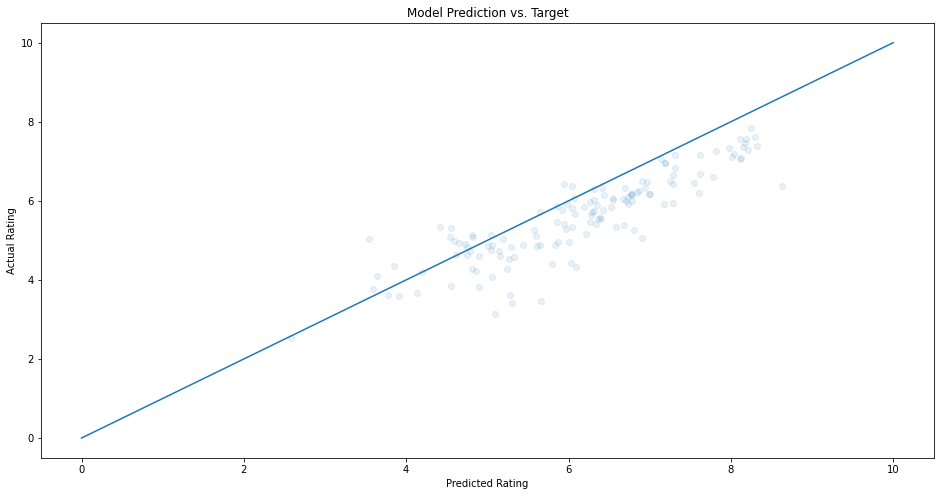

In [72]:
f = plt.figure(figsize=(16, 8))
plt.scatter(hub_predict, y_test, alpha = 0.1)
plt.plot(np.linspace(0, 10), np.linspace(0, 10))
plt.title('Model Prediction vs. Target')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating');

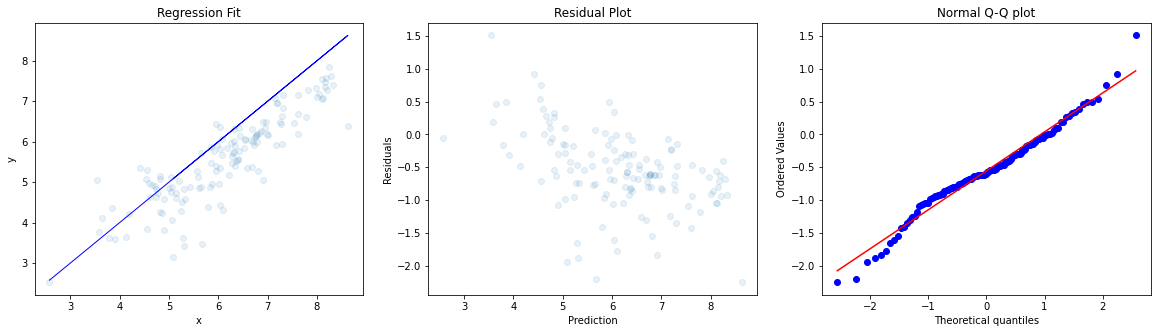

In [73]:
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize = (20,5))

    plt.subplot(1, 3, 1)
    plt.scatter(x, y, alpha = 0.1)
    plt.plot(x, x, color = "blue", linewidth = 1)
    plt.title("Regression Fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - x
    plt.scatter(x, res, alpha = 0.1)
    plt.title("Residual Plot")
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")
    
    plt.subplot(1, 3, 3)
    # Generates a probability plot of sample data against the quantiles of a specified theoretical distribution 
    stats.probplot(res, dist = "norm", plot = plt)
    plt.title("Normal Q-Q plot");

diagnostic_plot(hub_predict, y_test)

From this, we can see that although this does sound good in theory, it does not have very good results compared to just training an autoregression model on the score directly, as R^2 and MSE are both worse. This could be due to the linear model or equation in the 2021 dataset used to calculate Happiness Score being slightly different from 2020's one. This means that it may not be feasible to use this method to predict future scores. However, it may still be useful to do this just to see what the forecasted values of the variables will be in the future.

# 4. Vector Autoregression on Variables and Score

**VAR** is a multivariate forecasting algorithm that is used when two or more time series influence each other. For our data, certain variables such as **Trust**, may affect other variables, such as **Freedom**.

Our team has tried to implement VAR on our time series, however, we were unable to do so as the time series only had 7 entries and hence only lag of 0 could be used (which is just linear regression). In order to implement this, we need more data entries for world happiness statistics, which is unavailable. However, in theory, we believe that the VAR model will be the most effective in predicting score, as there is strong relationship between some variables to other variables. This can be shown via the correlation matrix below. Thus, if given the opportunity, we would have loved to try out VAR and compare it with the other models.


# Conclusion
Overall, this series of notebooks has allowed us to see exactly how a governing body can analyse and break down which factors are important and lead to a higher happiness score. They can make use of this in order to figure out which part of their country to focus on first in order to see immediate results.

They will also be able to forecast future variables (ceteris paribus) and also the forecast of future score. Using this, they can selectively see which part of the country may need improvement the most.

